<h1><center>Data Analysis</center></h1>
<h2><center>Kaggle report notebook</center></h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from PIL import Image
import requests
from io import BytesIO
import seaborn as sns
import sklearn
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

In [2]:
print(sklearn.__version__)

0.21.2


# Introduce yourself

Put your team name and team-members' names below

##### Team name: random_seed=42
 
##### Team members: Dmitry Gordeychuk, Oleg Samoylov, Vlada Vakulenko

# Data Loading

In [3]:
x_train = pd.read_csv('./train.tsv', sep='\t', index_col=0, encoding='UTF-8')
x_test = pd.read_csv('./test.tsv', sep='\t', index_col=0, encoding='UTF-8')
y_train = x_train['sold_fast']
x_train.drop(columns=['sold_fast'], inplace=True)

In [4]:
print('train:', x_train.shape, '\ntest:', x_test.shape)

train: (351281, 18) 
test: (89251, 18)


In [5]:
def get_picture(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

# Descriptive Data Analysis

* Analyze train dataset features
    * Provide some meaningfull description about corresponding features (in form of pictures or some coefficients)
    * Outline any findings you are able to reveal
* Try to measure analyse any correspondense between features and target features

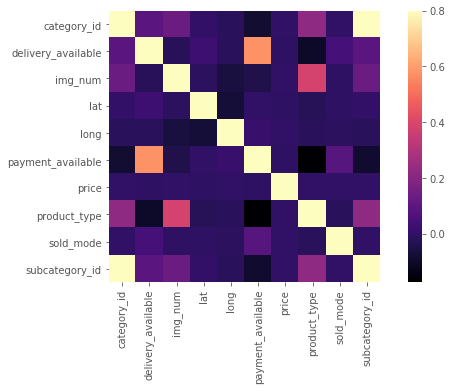

In [6]:
corr = x_train.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr, vmax=.8, square=True, cmap='magma');

E.g. feature named "Unnamed 0:" has no information, so it should be dropped. As heatmap says, it's clear that features majority are linearly independent. There is only one exception - very big correlation between features: $category$_ $ id$ and $subcategory$_$id$ which is caused of object types of these features, but implemented like int type. Overall we have a good oportunity to use some linear models. After all, we can use additional data, such as categorical features to make our model stronger.

Other analysis shows that given data doesn't contain any leaks or important features that should get higher weights. So we should use all data to get predicts on target 

# (almost) Zero-knowledge prediction
* Develop non-machine learning approach to get predictions
    * Describe it and measure its quality on Kaggle

In [7]:
y_pred_0 = np.random.uniform(0, 1, len(x_test))

In [8]:
ans = {'product_id': x_test['product_id'], 'score': y_pred_0}
pd.DataFrame(ans).to_csv('random.csv', index=False)

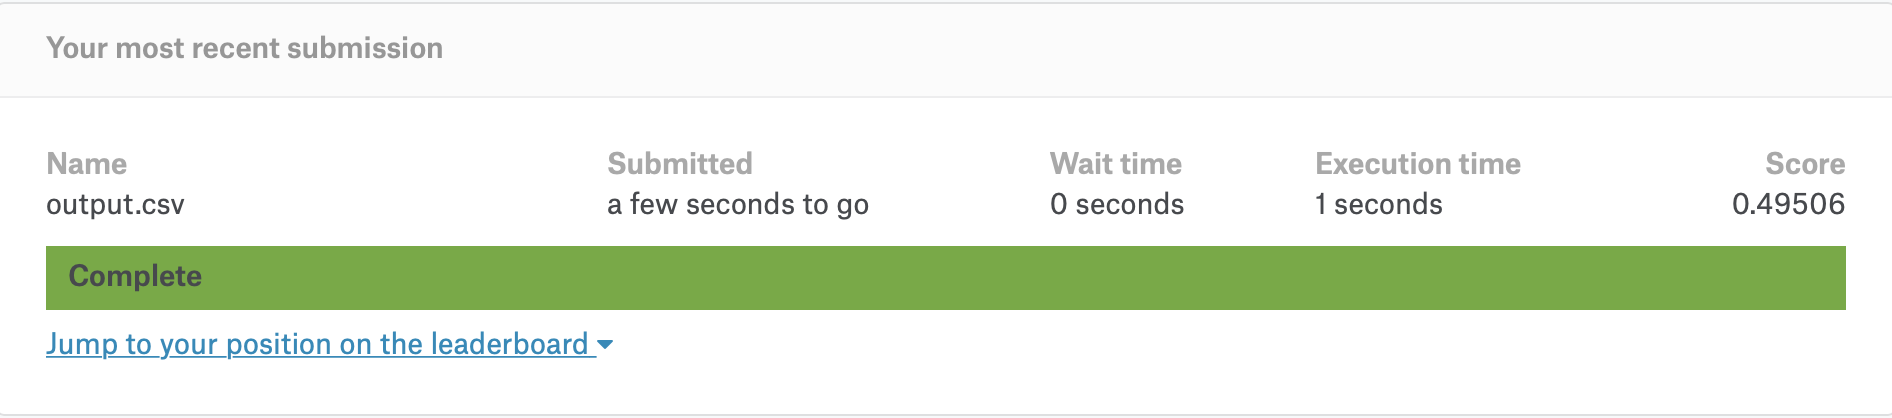

In [9]:
get_picture('https://cdn1.savepice.ru/uploads/2019/6/10/440e5436d878899c09f37071ee02bb31-full.png')

Obviously, we get ~0.5 ROC-AUC score on random classification. It's caused because of ranking a random positive example higher than a random negative example 50% of the time. Thus, classification model with such predictions is basically worthless, as its predictive ability is no better than random guessing.

# Machine-learning pipeline of preprocessing data

Here you develop your pipeline, generate features for train and test sets
* Your pipeline should be reproducible - make sure you set all `random_states` if needed

#### Step 1.

Extracting text features. Evaluating name and description of operation is very important when getting information about selling operation. So we use simplier version to transform text into vectors - called TF-IDF. Its a numerical statistic that is intended to reflect how important a word is to a document in a corpus. So we just concatened two features for each object and used TfIdfVectorizer on new corpuses. Result of this operation is Sparce Matrix which will be used later. Don't forget remove these features from our DataFrame.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
x_ti = tfidf.fit_transform(x_train['name_text'] + ' ' + x_train['desc_text'])
x_ti_t = tfidf.transform(x_test['name_text'] + ' ' + x_test['desc_text'])

In [11]:
x_train.drop(columns=['desc_text', 'name_text'], inplace=True)
x_test.drop(columns=['desc_text', 'name_text'], inplace=True)

#### Step 2.

Also we founded one numerical feature among categorical: date_created. So we transform it's objects from DD.MM.YYYY string format into 3 numerical columns [DD, MM, YYYY].

In [12]:
def date2ymd(date):
    date_plitted = date.split('-')
    return [int(date_plitted[0]), int(date_plitted[1]), int(date_plitted[2])]

x_train_dates = np.array([date2ymd(i) for i in x_train['date_created'].values])
x_test_dates = np.array([date2ymd(i) for i in x_test['date_created'].values])

In [13]:
x_train['year'], x_test['year'] = x_train_dates[:, 0], x_test_dates[:, 0]
x_train['month'], x_test['month'] = x_train_dates[:, 1], x_test_dates[:, 1]
x_train['day'], x_test['day'] = x_train_dates[:, 2], x_test_dates[:, 2]

In [14]:
x_train.drop(columns=['date_created'], inplace=True)
x_test.drop(columns=['date_created'], inplace=True)

#### Step 3.

Dividing other data into categorical and numerical features.
So we just check $df.columns$ and mark some features as categorical. Don't forget to do it for both: train & test. As a result we want to get 2 np.arrays of cat. and num. feature names.

In [15]:
cat_features = ['owner_id', 'category_id', 'city', 'subcategory_id', 'delivery_available', 
                'payment_available', 'product_id', 'product_type', 'region', 'sold_mode', 'properties']

In [16]:
for feature in cat_features:
    x_train[feature] = x_train[feature].astype('object')
    x_test[feature] = x_test[feature].astype('object')

In [17]:
obj_cols = x_train.columns[np.array(x_train.dtypes == 'object')]
num_cols = x_train.columns[np.array(x_train.dtypes != 'object')]

#### Step 4.

Extracting numerical features and normalizing it by MinMaxScaler. We tried to use StandartScaler too, but gave us less score as in later stages, as in final model submissions.

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train[num_cols] = scaler.fit_transform(x_train[num_cols])
x_test[num_cols] = scaler.transform(x_test[num_cols])

#### Step 4.

Extracting last, categorical features. We will use OneHotEncoding technique. It is providing very simple API to work with categorical data. But it has some problems, such as large amount of output features. It causes output not like a dense array, but sparce matrix. Same output we got from TfIdfVectorizer by transforming text features.

In [19]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore')
x_train_ohe = ohe.fit_transform(x_train[obj_cols])
x_test_ohe = ohe.transform(x_test[obj_cols])

#### Step 5.

Overall we got devided our dataset into 3 parts: numerical, categorical, texts. Features extracted from texts implemented as vectors in x_ti. Other categorical and numerical features preprocessed and laying as int64, float64 or object types in x_train. These dataframes has such columns and shapes:

In [20]:
print("Columns in x_train: \n", x_train.columns.values)
print("x_train shape:", x_train.shape)
print("x_ti shape:", x_ti.shape)

Columns in x_train: 
 ['category_id' 'city' 'delivery_available' 'img_num' 'lat' 'long'
 'owner_id' 'payment_available' 'price' 'product_id' 'product_type'
 'properties' 'region' 'sold_mode' 'subcategory_id' 'year' 'month' 'day']
x_train shape: (351281, 18)
x_ti shape: (351281, 250184)


# Finding a model and evaluating it on Kaggle

#### Now we present our best model with tuned hyperparameters by GridSearchCV. 

It's a blending model consist on two strong models, which final results presents as a mean of their answers. 

We use LightGBM classifier - gradient boosting framework that uses tree based learning algorithms for texts, presented as vectors - output from Tf-Idf vectorizer. So we just feed him our preprocessed data and get predict_proba of 1-st class. It would be our y_test_1.

On the other hand, we use CatBoostClassifier - another gradient boosting on decision trees. We feed them our x_train with obj_cols argument which contains categorical column-names. CatBoost is very good Categorical Boosting because we dont need to take care of preprocessing these features. He do it secretly from us. So we just feed him our x_train with num and cat features and get y_test_2 from him.

Final prediction looks like an average of taken predictions: (y_test_1 + y_test_2) / 2

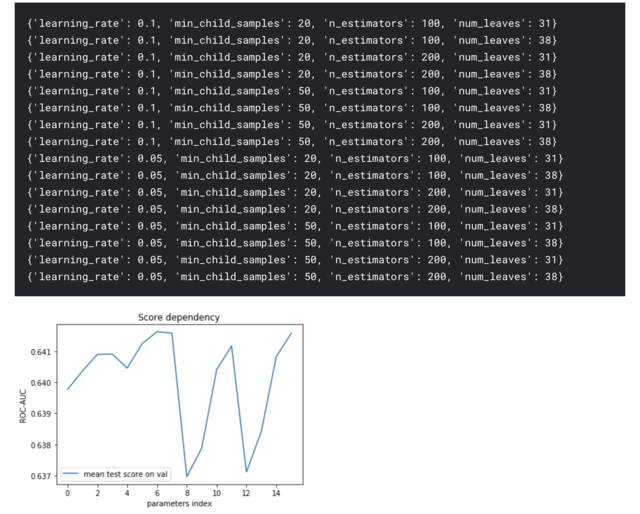

In [21]:
get_picture('https://cdn1.savepice.ru/uploads/2019/6/13/7dd57d3301517af05edf0674ba31692b-full.png')

In this graph and using method GridSearchCV.best_index_ we can see that the 5-th combination of parameters gives GridSearchCV.best_score_ in ROC-AUC mean folds score.

But we dont need to optimize hyperparameters to CatBoost because he has an adaptive learning rate. Very GOOD.

Model learning takes approximately 20 mins.

In [22]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(cat_features=obj_cols, loss_function='Logloss', verbose=False)
model.fit(x_train, y_train)
y_test_1 = model.predict_proba(x_test)[:, 1]

In [23]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=38,
    max_depth=-1,
    learning_rate=0.05,
    n_estimators=200,
    min_child_samples=50,
    random_state=0
)

model.fit(x_ti, y_train)
y_test_2 = model.predict_proba(x_ti_t)[:, 1]

In [24]:
y_test = (y_test_1 + y_test_2) / 2

ans = pd.DataFrame({'product_id': x_test['product_id'], 'score': y_test})
ans.head(3)

,product_id,score
0,86156cd607c3238af8982aebc99ae6a5,0.162995
3,76a35a1b4a2d869abfda3365d7cd4c45,0.139666
8,c339765b077a730a5367c5310c64128d,0.305102


In [25]:
ans.to_csv('output.csv', index=False)

Model results on Kaggle evaluation:

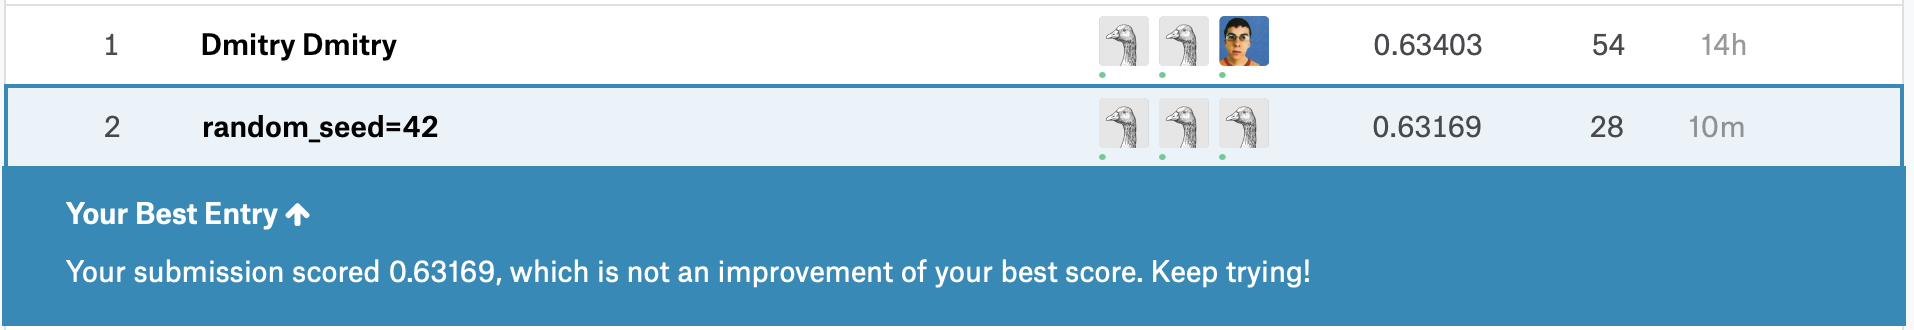

In [26]:
get_picture('https://cdn1.savepice.ru/uploads/2019/6/14/0cbd51bea4ddaa87d2c0ff68cd727280-full.png')

# Other tested worthless approaches

In the table below you can see model's score on Kaggle competition and short description of this approach.
All of these approaches you can find in our shared kaggle kernel.

0.57375 - Normalized Linear regression learned on OneHotEncoded data (version 5) [wrong model used]

0.59307 - Logistic Regression learned on OneHotEncoded data (version 7) [basically weak model]

0.58670 - Learned LogReg on TfIdf on text features and added his results as features to other OneHotEncoded data and then feeded it into LogReg model (version 10) [bad result because of target leaks into train - so - overfitting]

0.61351 - Cross-Validated on 5-folds Logistic Regression learned on OneHotEncoded data (version 11) [good, but not so good because of weak data preprocessing] 

0.61354 - Averaging results from 3 LogRegs, learned on: 1) StandartScaler normalized numeric features, 2) TF-IDF text features, 3) OneHotEncoded other categorical features (version 13)

0.59461 - LogReg learned only on OneHotEncoded categorical features, other num and text features are dropped. (version 15)

0.60186 - LogReg learned only on TF-IDF texts, other cat and num features are dropped. (version 17)

0.61635 - Averaging results from 3 LogRegsCV, learned on Cross-Validated data with 5-folds: 1) StandartScaler normalized numeric features, 2) TF-IDF text features, 3) OneHotEncoded other categorical features (version 18)

0.61133 - CatBoost on all data (version 19)

0.62264 - Averaging answers from 3 boostings: 1) CatBoost on categorical features, 2) XGBoost on StadartScaler normalized numerical features, 3) LightGBM on TF-IDF text features. (version 20)

0.61425 - XGBoost only on numerical features (version 21)

0.62320 - One strong LightGBM Boosting on concateneted sparce matrices. (version 23)

#### 0.63169 - Blending with LightGBM on texts and CatBoost on other categorical and numerical features (version 40)

# Model interpretation
Try to interpret your model results
* What **knowledge** does it reveal?

We think that our strongest model is very good on exact task. It get information about an item and special target-characteristic: was this item sold for 3 days, or not. Thus our model learning on this data to predict probability of positive class, implemented as probabilty of selling this item in 3 days.